# Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

We initially read the user table. Two fields (`creation_time` and `last_session_creation_time`) should be times, but `last_session_creation_time` is given as a Unix epoch timestamp. This won't be read as a date time using the `parse_dates` parameter, but can be converted later.

Since `opted_in_to_mailing_list` and `enabled_for_marketing_drip` are boolean, we explicitly convert them. Additionally, `invited_by_user_id` should be integer-typed, but the usual int type isn't nullable. We use Pandas Int64 type which is nullable.

In [2]:
users_df = pd.read_csv('./takehome_users.csv', 
                       parse_dates=['creation_time'], 
                       dtype= {'invited_by_user_id': 'Int64'})

In [3]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 949.3+ KB


In [5]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'],unit='s')

In [6]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240


In [7]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
dtypes: Int64(1), datetime64[ns](2), int64(4), object(3)
memory usage: 949.3+ KB


Now, read the engagement table. Here, the only optional argument is to read the `time_stamp` column as a datetime.

In [8]:
engage_df = pd.read_csv('./takehome_user_engagement.csv', parse_dates=['time_stamp'])

In [9]:
engage_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [10]:
engage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [11]:
engage_df.visited.unique()

array([1], dtype=int64)

In [12]:
engage_df.visited.value_counts()

1    207917
Name: visited, dtype: int64

There is no reason to continue carrying `visited` as a field as it adds nothing of value.

In [13]:
engage_df.drop('visited', axis=1, inplace=True)

# Feature Engineering

Most user data is present. There are two fields with null values - `last_session_creation_time` and `invited_by_user_id`. The latter is not surprising as we would not expect all users to join via invite. However, we might expect all users to have a `last_session_creation_time`. We can count the number of sessions per user.

In [14]:
session_count_df = engage_df.groupby('user_id').count()

It seems to be notable that there are 8823 rows in the grouped session data, the same as in the user data.

In [15]:
session_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   time_stamp  8823 non-null   int64
dtypes: int64(1)
memory usage: 137.9 KB


Change the field name to something more descriptive.

In [16]:
session_count_df.rename({'time_stamp': 'session_count'}, axis=1, inplace=True)

In [17]:
session_count_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   session_count  8823 non-null   int64
dtypes: int64(1)
memory usage: 137.9 KB


In [18]:
users_df = users_df.merge(session_count_df, how='left', left_on='object_id', right_index=True)

In [19]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               8823 non-null   float64       
dtypes: Int64(1), datetime64[ns](2), float64(1), int64(4), 

Unsurprisingly, session counts are zero for users with null `last_session_creation_time`.

In [20]:
users_df[users_df.last_session_creation_time.isna()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3177 entries, 7 to 11993
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   3177 non-null   int64         
 1   creation_time               3177 non-null   datetime64[ns]
 2   name                        3177 non-null   object        
 3   email                       3177 non-null   object        
 4   creation_source             3177 non-null   object        
 5   last_session_creation_time  0 non-null      datetime64[ns]
 6   opted_in_to_mailing_list    3177 non-null   int64         
 7   enabled_for_marketing_drip  3177 non-null   int64         
 8   org_id                      3177 non-null   int64         
 9   invited_by_user_id          1641 non-null   Int64         
 10  session_count               0 non-null      float64       
dtypes: Int64(1), datetime64[ns](2), float64(1), int64(4), o

In the `session_count` field, null values have a natural interpretation as a zero count.

In [21]:
users_df.fillna(value={'session_count': 0}, inplace=True)

In [22]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  float64       
dtypes: Int64(1), datetime64[ns](2), float64(1), int64(4), 

The `session_count` column can be cast to integer now since it no longer has null values.

In [23]:
users_df['session_count'] = users_df['session_count'].astype(int)

In [24]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  int32         
dtypes: Int64(1), datetime64[ns](2), int32(1), int64(4), ob

We'll add the number of invites from an individual user as well.

In [25]:
invites_df = users_df.groupby('invited_by_user_id')['object_id'].count()

In [26]:
invites_df.head()

invited_by_user_id
3     1
7     5
10    1
21    1
23    3
Name: object_id, dtype: int64

In [27]:
users_df = users_df.merge(invites_df, how='left', left_on='object_id', right_index=True)

In [28]:
users_df.rename({'object_id_x':'object_id', 'object_id_y': 'invite_count'},axis=1, inplace=True)

In [29]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  object        
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  int32         
 11  invite_count                2564 non-null   object    

The `object_id` field became object type. We will change it back.

In [30]:
users_df['object_id'] = users_df['object_id'].astype(int)

As earlier, it makes sense for all null `invite_count` entries to be zero.

In [31]:
users_df.fillna(value={'invite_count': 0}, inplace=True)

In [32]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int32         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  int32         
 11  invite_count                12000 non-null  int64     

Rather than track who a user was invited by, we can track simply whether they were invited or not.

In [33]:
users_df['was_invited'] = users_df['invited_by_user_id'].notna().astype(int)

In [34]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,session_count,invite_count,was_invited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14,0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1,1,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1,0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1,0,1


In [35]:
users_df.was_invited.value_counts()

1    6417
0    5583
Name: was_invited, dtype: int64

The field `org_id` is meaningless by itself, but we can track the number of users in each org grouping.

In [36]:
orgs_df = users_df[['object_id', 'org_id']].groupby('org_id').count()
orgs_df.rename({'object_id': 'org_count'}, axis=1, inplace=True)

In [37]:
orgs_df.head()

,org_count
org_id,
0,319
1,233
2,201
3,168
4,159


In [38]:
users_df = users_df.merge(orgs_df, how='left', left_on='org_id', right_index=True)

In [39]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,session_count,invite_count,was_invited,org_count
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1,0,1,75
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14,0,1,233
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1,1,1,32
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1,0,1,233
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1,0,1,16


In [40]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int32         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  int32         
 11  invite_count                12000 non-null  int64     

The specific time that an account was created is unlikely to tell us anything. However, we can determine how early/late the account was created relative to others.

In [41]:
min_creation_time = users_df.creation_time.min()
print(min_creation_time)

2012-05-31 00:43:27


In [42]:
users_df['creation_days_since_start'] = users_df['creation_time'] - min_creation_time

In [43]:
users_df['creation_days_since_start'] = users_df['creation_days_since_start'].apply(lambda x: x.days)

In [44]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,session_count,invite_count,was_invited,org_count,creation_days_since_start
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803,1,0,1,75,691
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316,14,0,1,233,533
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525,1,1,1,32,292
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151,1,0,1,233,355
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240,1,0,1,16,231


Most importantly, we need to determine whether or not users are adopted users. An adopted user is considered to be a user who has logged into the product on three separate days in at least one seven-day period. Since we're only given a single login timestamp for each session, we can't consider total session length.

In [45]:
users_df.session_count.describe()

count    12000.000000
mean        17.326417
std         64.287839
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max        606.000000
Name: session_count, dtype: float64

In [46]:
# At least three separate days are required over a single seven day period. 
REQUIRED_COUNT = 3
REQUIRED_LENGTH = 7

def is_adopted_user(timestamps):
    '''
    Given a series of timestamps corresponding to a user's session logins, determines whether that user is an adopted user.
    '''
    # If there aren't even three sessions, there can't be three different days. 
    if len(timestamps) < REQUIRED_COUNT:
        return False
    
    # Convert the timestamps to a list of dates.
    # Although we are allowed to assume no two rows for a single user duplicate dates, we can easily eliminate duplicates
    #   by assigning to a set and then back to a list.
    dates = [t.date() for t in timestamps]
    # Sort the dates to make counting work easier.
    dates.sort()
    
    # Iterate over 3 session groups.
    # We compare the first session (index 0) with the third session (index 2) to determine if there are fewer than seven
    #   days passing between the sessions. If the time difference is seven days or more, the sessions weren't in the same
    #   seven day period. For example, if sessions are on January 1st, 4th, and 8th, then the time difference will be
    #   seven days, but the sessions were in an 8 day period.
    jmp = REQUIRED_COUNT - 1
    n = len(dates) - jmp
    for i in range(n):
        first_session = dates[i]
        last_session = dates[i + jmp]
        time_diff = last_session - first_session
        
        # time_diff is a dt.timedelta. Check the number of days in the period.
        if time_diff.days < REQUIRED_LENGTH:
            return True
    
    # Fall through. Iterating over the sessions found no acceptable adoption period. There were enough sessions to 
    #   potentially be an adopted user, but the sessions were too far apart.
    return False

In [47]:
# Broadcast a default value of False, then update users which are true.
users_df['is_adopted'] = 0
for user in engage_df.groupby('user_id'):
    user_no = user[0]
    timestamps = user[1].time_stamp
    if is_adopted_user(timestamps):
        users_df.loc[user_no, 'is_adopted'] = 1

In [48]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int32         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   Int64         
 10  session_count               12000 non-null  int32         
 11  invite_count                12000 non-null  int64     

In [49]:
users_df.is_adopted.value_counts()

0    10398
1     1602
Name: is_adopted, dtype: int64

In [50]:
print(f'{1602/8823:0.3%}')

18.157%


In [51]:
print(f'{1602/12000:0.3%}')

13.350%


Of the 8823 users who logged in at least once, only 1602 (18.157%, 13.350% of all users) became adopted.

Of the remaining fields, `object_id`, `name` and `email` will not play a role in the analysis. Additionally, `creation_time`, `org_id`, `last_session_creation_time` and `invited_by_user_id` are now largely covered by other fields.

In [52]:
users_df.set_index('object_id',drop=True, inplace=True)

In [53]:
users_df.drop(['name', 'email', 'creation_time', 'org_id', 'last_session_creation_time', 'invited_by_user_id'], 
              axis=1, inplace=True)

In [54]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   creation_source             12000 non-null  object
 1   opted_in_to_mailing_list    12000 non-null  int64 
 2   enabled_for_marketing_drip  12000 non-null  int64 
 3   session_count               12000 non-null  int32 
 4   invite_count                12000 non-null  int64 
 5   was_invited                 12000 non-null  int32 
 6   org_count                   12000 non-null  int64 
 7   creation_days_since_start   12000 non-null  int64 
 8   is_adopted                  12000 non-null  int64 
dtypes: int32(2), int64(6), object(1)
memory usage: 843.8+ KB


In [55]:
users_df = pd.concat(
        [users_df.drop('creation_source',axis=1), pd.get_dummies(users_df['creation_source'], prefix='source')],
         axis=1)

In [56]:
users_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,session_count,invite_count,was_invited,org_count,creation_days_since_start,is_adopted,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,,,,
1,1,0,1,0,1,75,691,0,1,0,0,0,0
2,0,0,14,0,1,233,533,0,0,1,0,0,0
3,0,0,1,1,1,32,292,1,0,1,0,0,0
4,0,0,1,0,1,233,355,0,1,0,0,0,0
5,0,0,1,0,1,16,231,0,1,0,0,0,0


In [57]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   opted_in_to_mailing_list    12000 non-null  int64
 1   enabled_for_marketing_drip  12000 non-null  int64
 2   session_count               12000 non-null  int32
 3   invite_count                12000 non-null  int64
 4   was_invited                 12000 non-null  int32
 5   org_count                   12000 non-null  int64
 6   creation_days_since_start   12000 non-null  int64
 7   is_adopted                  12000 non-null  int64
 8   source_GUEST_INVITE         12000 non-null  uint8
 9   source_ORG_INVITE           12000 non-null  uint8
 10  source_PERSONAL_PROJECTS    12000 non-null  uint8
 11  source_SIGNUP               12000 non-null  uint8
 12  source_SIGNUP_GOOGLE_AUTH   12000 non-null  uint8
dtypes: int32(2), int64(6), uint8(5)
memory usage: 808.6 KB


# EDA

In [58]:
users_df.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,session_count,invite_count,was_invited,org_count,creation_days_since_start,is_adopted,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,17.326417,0.534750,0.534750,55.108500,411.029083,0.133500,0.180250,0.354500,0.175917,0.173917,0.115417
std,0.432742,0.356432,64.287839,1.350473,0.498812,64.023959,216.641508,0.340128,0.384412,0.478381,0.380765,0.379054,0.319537
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,229.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.000000,1.000000,29.000000,431.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,1.000000,0.000000,1.000000,55.000000,607.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,606.000000,13.000000,1.000000,319.000000,729.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Set aside users who login at least three times, as these are the only users that could potentially become adopted.

In [59]:
heavy_users = users_df.session_count >= 3

In [60]:
print(heavy_users.sum())

2248


Normalize features.

In [61]:
users_df /= users_df.max()

In [62]:
users_df.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,session_count,invite_count,was_invited,org_count,creation_days_since_start,is_adopted,source_GUEST_INVITE,source_ORG_INVITE,source_PERSONAL_PROJECTS,source_SIGNUP,source_SIGNUP_GOOGLE_AUTH
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.249500,0.149333,0.028591,0.041135,0.534750,0.172754,0.563826,0.133500,0.180250,0.354500,0.175917,0.173917,0.115417
std,0.432742,0.356432,0.106086,0.103883,0.498812,0.200702,0.297176,0.340128,0.384412,0.478381,0.380765,0.379054,0.319537
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.006270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.065831,0.314129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.001650,0.000000,1.000000,0.090909,0.591221,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.001650,0.000000,1.000000,0.172414,0.832647,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


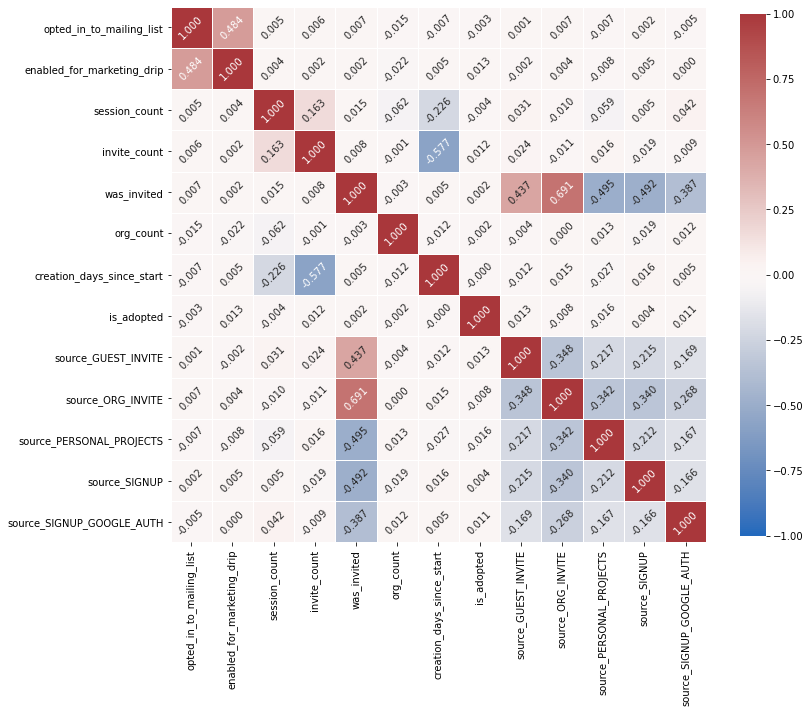

In [63]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(users_df.corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, center=0, fmt='0.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={'rotation': 45});

The field `is_adopted` has little correlation with other fields at first glance. This remains the same when looking only at users with three or more sessions.

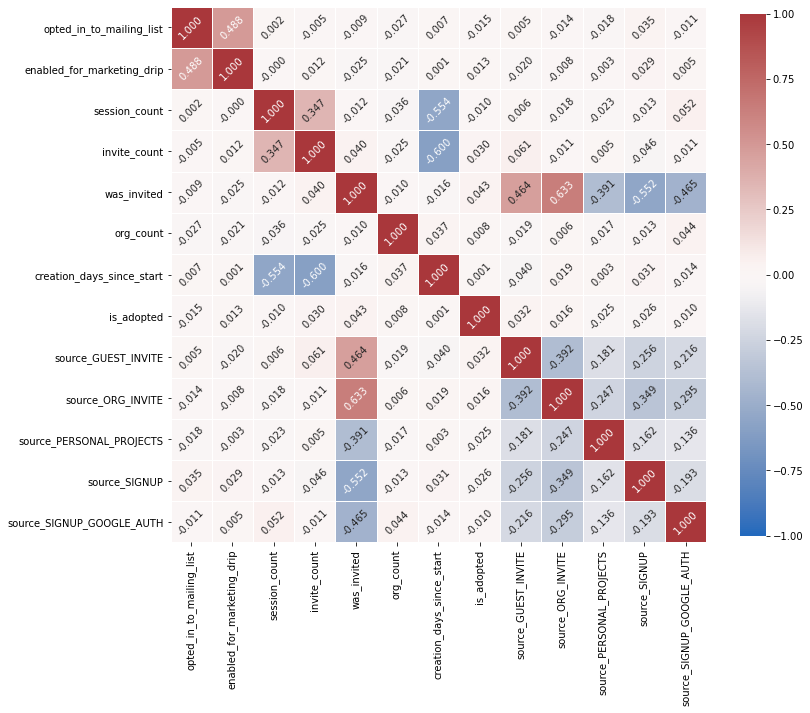

In [64]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(users_df[heavy_users].corr(), cmap='vlag', vmin=-1, vmax=1, annot=True, center=0, fmt='0.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={'rotation': 45});

## PCA Reduction

In [65]:
pca = PCA(n_components='mle')
pca.fit(users_df)
print(pca.explained_variance_ratio_)

[0.30428704 0.14882342 0.14179749 0.10967543 0.08095315 0.07232482
 0.05807643 0.04797481 0.02522506 0.00656011 0.00430223]


In [66]:
np.cumsum(pca.explained_variance_ratio_)

array([0.30428704, 0.45311046, 0.59490795, 0.70458339, 0.78553654,
       0.85786136, 0.91593779, 0.9639126 , 0.98913766, 0.99569777,
       1.        ])

The PCA reduction only eliminates two dimensions, so we don't gain much.

# Model Fitting

There is some imbalance in our target feature, so we stratify when creating our train/test splits.

In [67]:
X = users_df.drop('is_adopted', axis=1)
y = users_df['is_adopted']
TEST_SIZE = 0.20
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=users_df['is_adopted'], 
                                                    random_state=RANDOM_STATE)

In [68]:
scores = {}
def score_classifier(name, y_true, y_pred):
    clf_scores = {}
    clf_scores['acc'] = metrics.accuracy_score(y_true, y_pred)
    clf_scores['bal_acc'] = metrics.balanced_accuracy_score(y_true, y_pred)
    clf_scores['f1'] = metrics.f1_score(y_true, y_pred)
    clf_scores['prec'] = metrics.precision_score(y_true, y_pred, zero_division=0)
    clf_scores['rec'] = metrics.recall_score(y_true, y_pred)
    scores[name] = clf_scores

In [69]:
def train_and_score_classifier(name, clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score_classifier(name, y_test, y_pred)

In [70]:
def print_classifier_scores(name):
    clf_scores = scores[name]
    print(f'Accuracy: {clf_scores["acc"]}')
    print(f'Balanced Accuracy: {clf_scores["bal_acc"]}')
    print(f'F1: {clf_scores["f1"]}')
    print(f'Precision: {clf_scores["prec"]}')
    print(f'Recall: {clf_scores["rec"]}')

## Baselines

Two dummy classifiers are trained to provide baselines. The first always chooses the majority class and the second makes a random choice based on the proportion of adopted users in the data set.

In [71]:
dummy_freq_clf = DummyClassifier(strategy="most_frequent")
train_and_score_classifier('dummy_freq', dummy_freq_clf)
print_classifier_scores('dummy_freq')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


In [72]:
dummy_strat_clf = DummyClassifier(strategy="stratified", random_state=RANDOM_STATE)
train_and_score_classifier('dummy_strat', dummy_strat_clf)
print_classifier_scores('dummy_strat')

Accuracy: 0.7679166666666667
Balanced Accuracy: 0.5038461538461538
F1: 0.14175654853620953
Precision: 0.1398176291793313
Recall: 0.14375


## Logistic Regression

It seems that logistic regression on its own always predicts no adoption.

In [73]:
lr_clf = LogisticRegression()
train_and_score_classifier('logistic', lr_clf)
print_classifier_scores('logistic')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


A balanced regression is an improvement.

In [74]:
bal_lr_clf = LogisticRegression(class_weight='balanced')
train_and_score_classifier('bal_logistic', bal_lr_clf)
print_classifier_scores('bal_logistic')

Accuracy: 0.5645833333333333
Balanced Accuracy: 0.508173076923077
F1: 0.2089326267978804
Precision: 0.13786213786213786
Recall: 0.43125


In [75]:
lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear')
train_and_score_classifier('logistic_l1_reg', lr_l1_clf)
print_classifier_scores('logistic_l1_reg')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


In [76]:
bal_lr_l1_clf = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced')
train_and_score_classifier('bal_logistic_l1_reg', bal_lr_l1_clf)
print_classifier_scores('bal_logistic_l1_reg')

Accuracy: 0.56125
Balanced Accuracy: 0.5049278846153846
F1: 0.20648078372268272
Precision: 0.13604766633565044
Recall: 0.428125


## KNN

In [77]:
knn_clf = KNeighborsClassifier()
train_and_score_classifier('knn_reg', knn_clf)
print_classifier_scores('knn_reg')

Accuracy: 0.85375
Balanced Accuracy: 0.49519230769230765
F1: 0.011267605633802818
Precision: 0.05714285714285714
Recall: 0.00625


## Ridge Regression

In [78]:
rc_clf = RidgeClassifier()
train_and_score_classifier('ridge', rc_clf)
print_classifier_scores('ridge')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


In [79]:
bal_rc_clf = RidgeClassifier(class_weight='balanced')
train_and_score_classifier('bal_ridge', bal_rc_clf)
print_classifier_scores('bal_ridge')

Accuracy: 0.56375
Balanced Accuracy: 0.5076923076923077
F1: 0.2086167800453515
Precision: 0.13758723828514458
Recall: 0.43125


## Naive Bayes

In [80]:
nb_clf = BernoulliNB()
train_and_score_classifier('naive_bayes', nb_clf)
print_classifier_scores('naive_bayes')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


## Random Forests

Unlike with logistic regression, balancing the class weight doesn't improve the random forest results.

In [81]:
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)
train_and_score_classifier('random_forest', rf_clf)
print_classifier_scores('random_forest')

Accuracy: 0.8445833333333334
Balanced Accuracy: 0.4938701923076923
F1: 0.02610966057441253
Precision: 0.07936507936507936
Recall: 0.015625


In [82]:
bal_rf_clf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)
train_and_score_classifier('bal_random_forest', bal_rf_clf)
print_classifier_scores('bal_random_forest')

Accuracy: 0.845
Balanced Accuracy: 0.4927884615384615
F1: 0.02105263157894737
Precision: 0.06666666666666667
Recall: 0.0125


## Support Vector Classifier

In [83]:
svc_clf = LinearSVC(dual=False)
train_and_score_classifier('svc', svc_clf)
print_classifier_scores('svc')

Accuracy: 0.8666666666666667
Balanced Accuracy: 0.5
F1: 0.0
Precision: 0.0
Recall: 0.0


As with logistic regression, we see a slight improvement with a balanced class weight.

In [84]:
bal_svc_clf = LinearSVC(class_weight='balanced', dual=False)
train_and_score_classifier('bal_svc', bal_svc_clf)
print_classifier_scores('bal_svc')

Accuracy: 0.5633333333333334
Balanced Accuracy: 0.5074519230769231
F1: 0.2084592145015106
Precision: 0.13745019920318724
Recall: 0.43125


## Gradient Boosting

In [85]:
gb_clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE)
train_and_score_classifier('grad_boost', gb_clf)
print_classifier_scores('grad_boost')

Accuracy: 0.8658333333333333
Balanced Accuracy: 0.49951923076923077
F1: 0.0
Precision: 0.0
Recall: 0.0
